# Section along 113$^{\circ}$E: comparison of model with Pena-Molino et al. (2016) moorings

The ASC and its vertical structure is quite variable in time. It's questionable to validate (compare) the model with observations that are based on a snapshot in time (e.g. Chavanne et al. (2010), Fig 2 shows very different structure a month apart). It is better to compare the model mean transport and variability to observed values (e.g. from moorings or gliders). Pena-Molino et al.'s (2016) mooring data offer such an observational data set. 

This script
1. uses a 10 year climatology from the ACCESS-OM2-01 RYF simulation to compare the mean state, and
2. uses 1 year of daily data for the comparison of the transport.

Load modules:

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
# Optional modules
import scipy.io
# Optional modules (for plotting)
#from collections import OrderedDict
#import cftime
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import cmocean as cm 
from palettable.scientific.diverging import Vik_5
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores:

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36797 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 22.46 GiB


## Load observational data set (Pena-Molino et al. 2016)

1 - Daily data

In [3]:
# Path to data
PM2016_path = '/g/data/x77/wgh581/Other_Data/PM_2016/'
# Load data
file_name = 'tseries.mat'
tseries   = scipy.io.loadmat(PM2016_path + file_name)
ts_time   = tseries['gtime']
ts_total  = tseries['maxTXT']

2 - Mean field

In [4]:
# Load in observations: mooring data
file_name = 'mean_moor.mat'
mean_moor = scipy.io.loadmat(PM2016_path + file_name)
moor_glat = mean_moor['glat'][0,:] # Latitude
moor_zc   = mean_moor['zc'][:,0]   # Depth
moor_mu   = mean_moor['mu']/100    # Velocity

In [5]:
# Depth = deepest mooring measurement
max_depth_moor = np.zeros(len(moor_glat))
for ii in range(len(moor_glat)):
    index_tmp = int(np.argwhere(np.isnan(moor_mu[11:,ii]))[0]) + 11
    max_depth_moor[ii] = moor_zc[index_tmp-2]

In [6]:
# Load in observations: geostrophic data
file_name = 'mean_gshear.mat'
mean_gshear = scipy.io.loadmat(PM2016_path + file_name)
gshear_glat = mean_gshear['glat'][0,:] # Latitude
gshear_zc   = mean_gshear['zc'][:,0]   # Depth
gshear_gu   = mean_gshear['gu']/100    # Velocity

3 - Location and depth of mooring instruments

In [7]:
# Latitude and depth of mooring instruments
lat_moorings = [-65.32, -64.88, -64.40, -63.26, -61.83]
lon_moorings = [112.935, 113.293, 113.5, 113.33, 113.287]
Depth_M1 = [505, 1006]
Depth_M2 = [496, 1497]
Depth_M3 = [501, 1000, 2498]
Depth_M4 = [507, 2006, 3002, 3505]
Depth_M5 = [980, 1980, 2980, 3675, 4178]

## Load model data

Nominate a database from which to load the data and define an experiment.

In [8]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

1 - Mean field  

In [9]:
# Define a start and end time to load data from (10 years)
start_time = '2080-01-01'
end_time   = '2089-12-31'
# Section is along 113.3 E and from 65.3 to 61.8

# Import velocity
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(xu_ocean=-360+113.3, method='nearest').sel(yu_ocean=slice(-65.5,-58))  # -65.3,-61.8

# Get monthly climatology
u = u.groupby('time.month').mean('time')

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(xu_ocean=-360+113, method='nearest').sel(yu_ocean=slice(-65.5,-58))
hu.load()
hu[np.isnan(hu)] = 0

The time averaged data from PM2016 is from Jan 2010 to May 2011, which equals to 17 months. To achieve the best comparison, we average the model data over the same climatological months.

In [10]:
u_yearly = (u.mean('month') * 12 + u[:5, :,:].mean('month') * 5 ) / 17
u_yearly.load();

2 - Daily transport in mooring quadrant

In [11]:
start_time = '2086-01-01'
end_time   = '2086-12-31'

uhrho = cc.querying.getvar(expt, 'uhrho_et', session, start_time=start_time, end_time=end_time, ncfile="ocean_daily_3d_uhrho_%.nc")

# In model: section along 113.3 (varies a little in observations, but if we change it in the model we loose information on area -> cannot calculate transport)
uhrho = uhrho.sel(xt_ocean=-360+113.3, method='nearest').sel(yt_ocean=slice(-65.3, -61.8))
uhrho_upper = uhrho.sel(time=slice(start_time,end_time)).sel(st_ocean=slice(0, 500))
uhrho_lower = uhrho.sel(time=slice(start_time,end_time)).sel(st_ocean=slice(500, 4500))

# Divide by constant density value to get u*dz
rho_val  = 1035
uh_upper = uhrho_upper/rho_val
uh_lower = uhrho_lower/rho_val

Get dyt to calculate the full transport (daily data doesn't give us the full transport). The uhrho variable is on the t-grid, hence we need to use dyt (instead of dyu). 

In [12]:
dyt = cc.querying.getvar(expt, 'dyt', session, start_time=start_time, end_time=end_time, n=1)
# Select indices manually (checked with uhrho for correct lon/lat)
dyt = dyt[375:453,330]
# Rename dimension
dyt = dyt.rename(({'nj':'yt_ocean'}))

Maximum cumulative westward transport
- calculate the transport as `(uh) * dyt` 
- convert to Sverdrup (1 Sv = 10$^6$ m$^3$s$^{-1}$)
- select max westward (that is the minimum in data) transport

In [13]:
# Calculate transport for each grid cell, convert to Sv
transport_upper = uh_upper * dyt * 1e-6
transport_lower = uh_lower * dyt * 1e-6
# Integrate vertically
transport_upper = transport_upper.sum('st_ocean')
transport_lower = transport_lower.sum('st_ocean')
# Sum over lower and upper for total transport
transport_total = transport_upper + transport_lower

In [14]:
# Max cumulative westward transport:
transport_total = transport_total.cumsum('yt_ocean')
transport_total_max = transport_total.min('yt_ocean')
transport_total_max.load()
transport_lower = transport_lower.cumsum('yt_ocean')
transport_lower_max = transport_lower.min('yt_ocean')
transport_lower_max.load();

In [15]:
# Time average
transport_total_mean = transport_total_max.mean('time')
transport_lower_mean = transport_lower_max.mean('time')

## Plotting

In [16]:
fig_path = '/g/data/x77/wgh581/Figures/'
ft_size  = 20
lw = 2

In [17]:
# Get depth of max velocity data (to indicate bathymetry)

# Model data
st_model = np.zeros(np.size(u_yearly,1))
for ii in range(len(st_model)):
    st_tmp = np.where(np.isnan(u_yearly[:,ii])==False, u_yearly.st_ocean, np.nan)
    st_model[ii] = st_tmp[np.argmax(st_tmp)-1]
    
# Observational data
st_obs = np.zeros(np.size(moor_mu,1))
for ii in range(len(st_obs)):
    st_tmp = np.where(np.isnan(moor_mu[::,ii])==False, moor_zc, np.nan)
    st_obs[ii] = st_tmp[15+np.argmax(st_tmp[15:])-1]

In [19]:
# Mask land area
u_yearly_masked = np.ma.masked_where(np.isnan(u_yearly), u_yearly)
moor_mu_masked  = np.ma.masked_where(np.isnan(moor_mu), moor_mu)

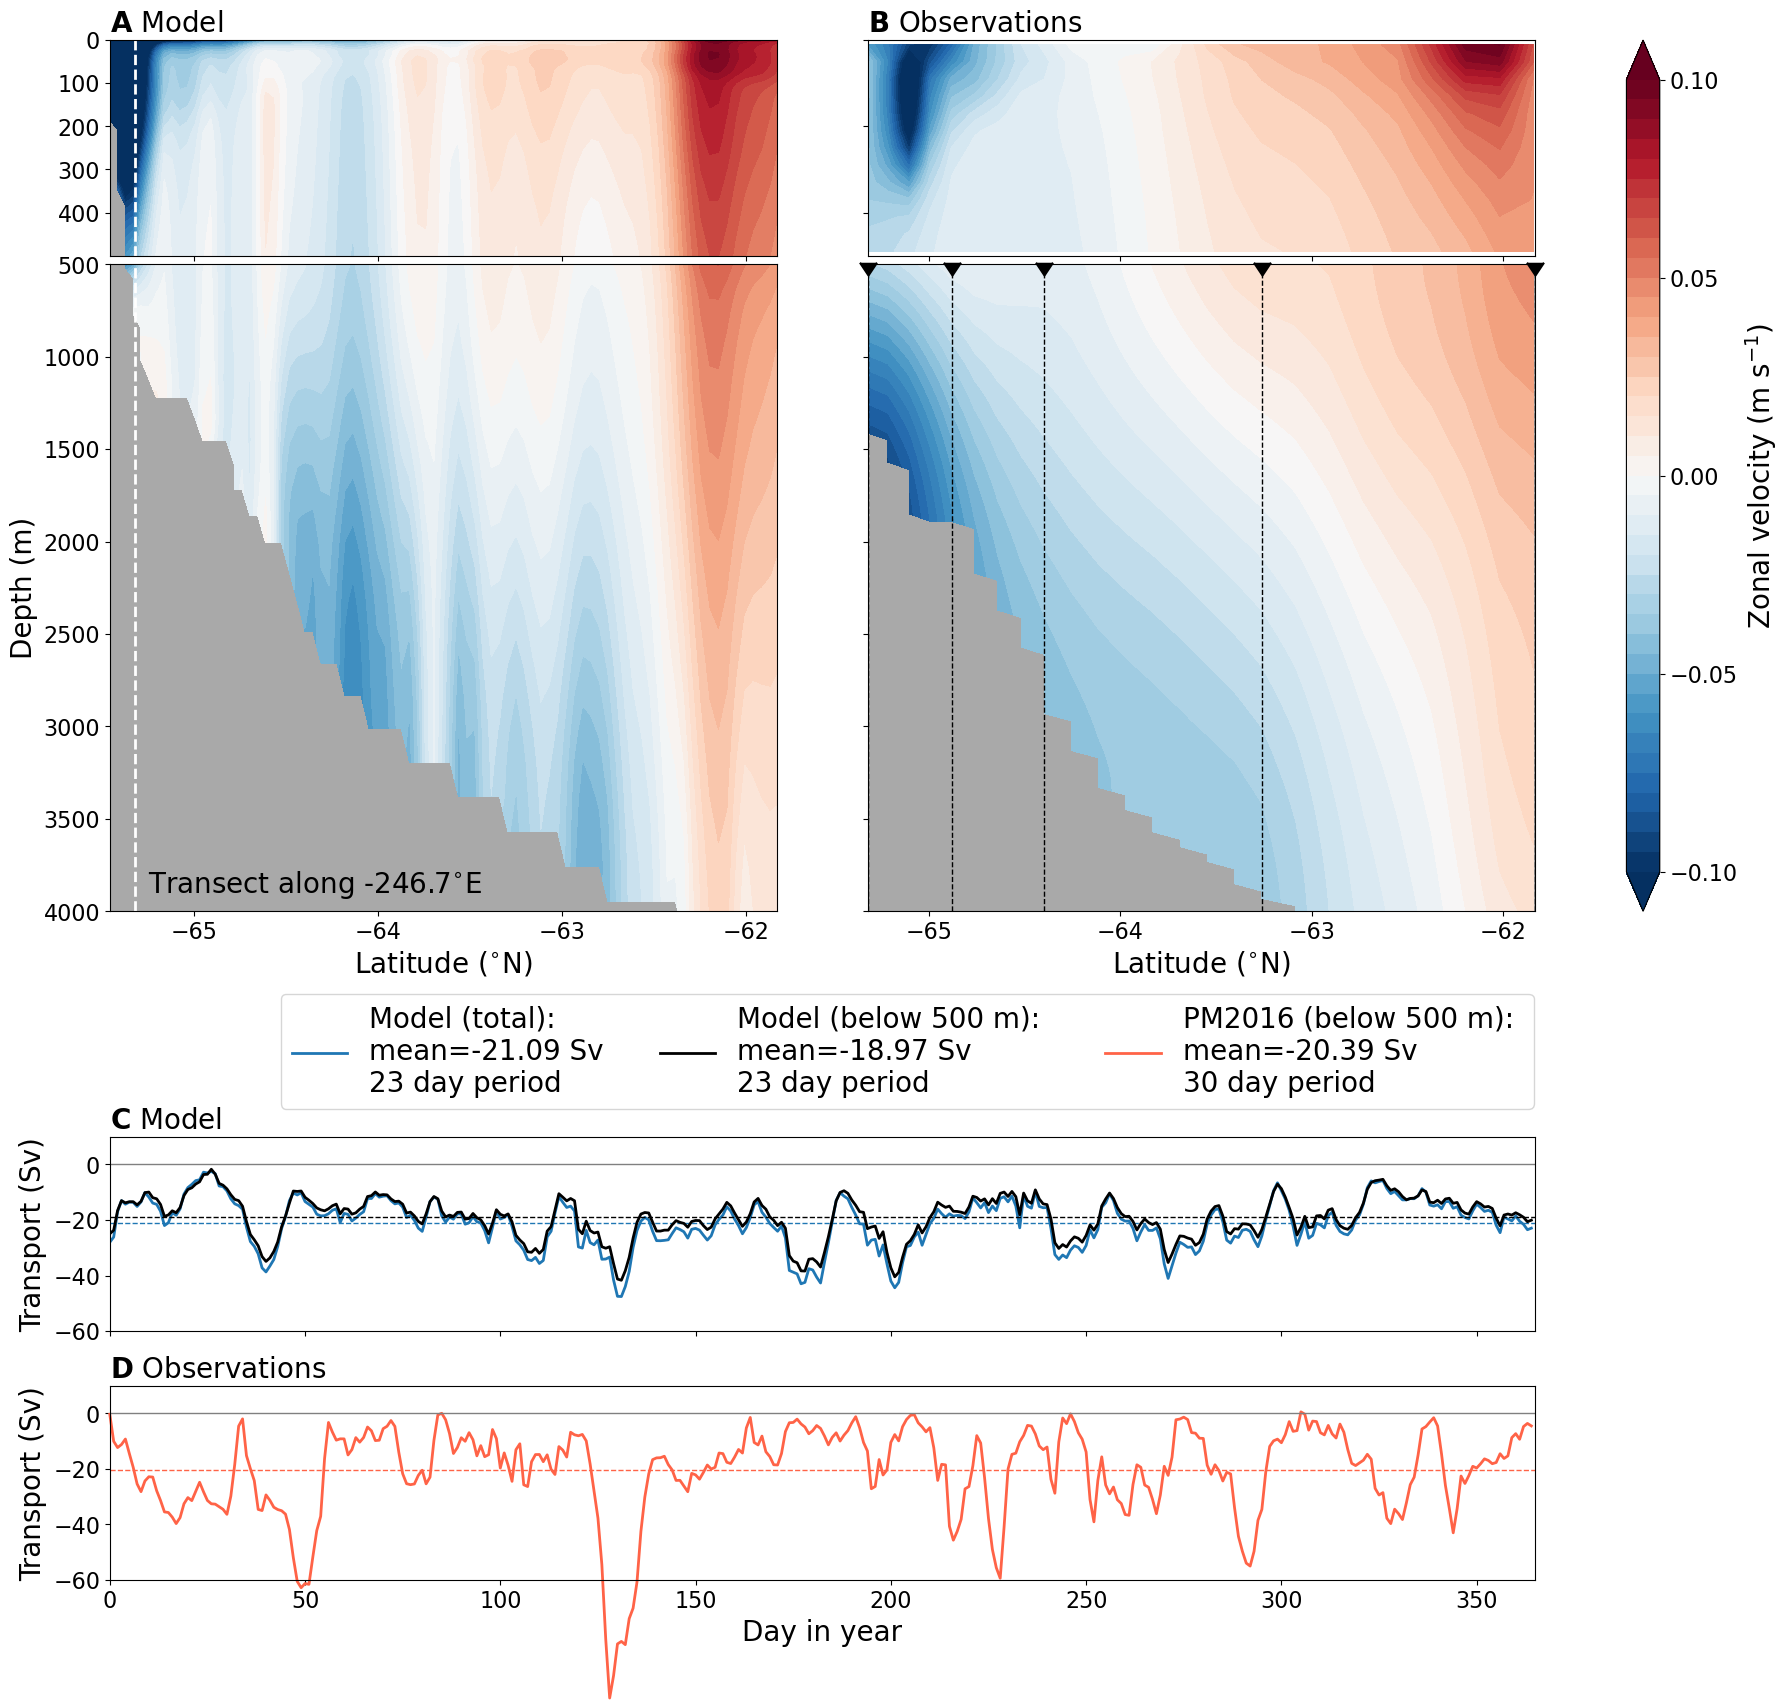

In [24]:
# Setting up figure
fig = plt.figure(figsize=(20,20))

# Subplots
gs   = GridSpec(2, 1, height_ratios=[4, 3], hspace=0.02, wspace=0.1)
gs_1 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0,:], hspace=0.02, height_ratios=[1, 3], width_ratios=[1, 1, 0.05])
gs_2 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1,:], hspace=0.3, height_ratios=[.8, 1, 1], width_ratios=[1, 1, 0.05])
ax1  = fig.add_subplot(gs_1[0,0])
ax2  = fig.add_subplot(gs_1[1,0])
ax3  = fig.add_subplot(gs_1[0,1])
ax4  = fig.add_subplot(gs_1[1,1])

# Transport time series (plot first, otherwise the legend does not really work)
label_names = ['Model (total): \nmean=%.2f Sv\n23 day period'%transport_total_mean, \
               'Model (below 500 m): \nmean=%.2f Sv\n23 day period'%transport_lower_mean, \
               'PM2016 (below 500 m): \nmean=%.2f Sv\n30 day period'%np.mean(ts_total[0,:365])]
for ii in range(2):
    ax = fig.add_subplot(gs_2[ii+1,:2])
    if ii == 0:
        # Model
        l1 = ax.plot(transport_total_max, color='C0', linewidth=lw, label='Model (total): \nmean=%.2f Sv\n23 day period'%transport_total_mean)
        ax.axhline(transport_total_mean, color='C0', linewidth=lw-1, label='_nolegend_', linestyle='dashed')
        l2 = ax.plot(transport_lower_max, color='k', linewidth=lw, label='Model (below 500 m): \nmean=%.2f Sv\n23 day period'%transport_lower_mean)
        ax.axhline(transport_lower_mean, color='k', linewidth=lw-1, label='_nolegend_', linestyle='dashed')
        plt.title(r'$\bf{C}$ Model', fontsize=ft_size, loc='left')
        plt.tick_params(labelbottom=False)
        plt.ylabel('Transport (Sv)', fontsize=ft_size)
    elif ii == 1:
        # Observations
        l3 = ax.plot(ts_total[0,:365], color='tomato', linewidth=lw, label='PM2016 (below 500 m): \nmean=%.2f Sv\n30 day period'%np.mean(ts_total[0,:365]), clip_on = False)
        ax.axhline(np.mean(ts_total[0,:365]), color='tomato', linewidth=lw-1, label='_nolegend_', linestyle='dashed')
        plt.title(r'$\bf{D}$ Observations', fontsize=ft_size, loc='left') 
        plt.xlabel('Day in year', fontsize=ft_size)
        plt.ylabel('Transport (Sv)', fontsize=ft_size)
    plt.axhline(0, color='0.5', linewidth=1, label='_nolegend_')
    plt.ylim(-60, 10)
    plt.xlim(0, 365)
    plt.xticks(fontsize=ft_size-4)
    plt.yticks(np.arange(-60, 20, 20), fontsize=ft_size-4)
fig.legend([l1, l2, l3], labels=label_names, fontsize=ft_size, ncol=3, bbox_to_anchor=(0.844, 0.41)) # (0.8875, 1.1)

# Model velocity transect
# Upper 500 m
ax1.set_title(r'$\bf{A}$ Model', fontsize=ft_size, loc='left')
ax1.fill_between(u_yearly.yu_ocean, 500, 0, color='darkgrey')
sc = ax1.contourf(u_yearly.yu_ocean, u_yearly.st_ocean, u_yearly_masked, levels=np.arange(-0.1,0.1,0.005), zorder=1, cmap='RdBu_r', extend='min')
#ax1.fill_between(hu.yu_ocean, hu, 4000, zorder=3, color='darkgrey')
ax1.set_ylim((500, 0))
ax1.set_xlim((u_yearly.yu_ocean.min(), np.max(lat_moorings)))
ax1.tick_params(labelbottom=False, labelsize=ft_size-4)  
ax1.axvline(lat_moorings[0], color='w', linewidth=2, linestyle='dashed', label='_nolegend_')
ax1.set_yticks(np.arange(0, 500, 100))
ax1.set_xticks(np.arange(-65, -61, 1))
# Below 500 m
ax2.fill_between(u_yearly.yu_ocean, 4000, 500, color='darkgrey')
SC = ax2.contourf(u_yearly.yu_ocean, u_yearly.st_ocean, u_yearly_masked, levels=np.arange(-0.1,0.1005,0.005), zorder=1, cmap='RdBu_r')
#ax2.fill_between(hu.yu_ocean, hu, 4000, zorder=1, color='darkgrey')
ax2.set_ylim((4000, 500))
ax2.set_xlim((u_yearly.yu_ocean.min(), np.max(lat_moorings)))
ax2.set_ylabel('Depth (m)', fontsize=ft_size)
ax2.set_xlabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
ax2.tick_params(labelsize=ft_size-4) 
ax2.axvline(lat_moorings[0], color='w', linewidth=2, linestyle='dashed', label='_nolegend_', zorder=2)
ax2.set_xticks(np.arange(-65, -61, 1))
ax2.text(-65.25, 3900, 'Transect along -246.7$^{\circ}$E', fontsize=ft_size)  # -65.325, 'Transect along 113.3$^{\circ}$E'

# Observation velocity transect
# Upper 500 m
ax3.set_title(r'$\bf{B}$ Observations', fontsize=ft_size, loc='left')
SC = ax3.contourf(gshear_glat, gshear_zc, gshear_gu, levels=np.arange(-0.1,0.1005,0.005), zorder=1, cmap='RdBu_r', extend='both')
ax3.set_ylim((500, 0))
ax3.tick_params(labelbottom=False, labelleft=False, labelsize=ft_size-4)  
ax3.set_xlim(np.min(lat_moorings), np.max(lat_moorings))
ax3.set_xticks(np.arange(-65, -61, 1))
# Below 500 m
ax4.fill_between(u_yearly.yu_ocean, 4000, 500, color='darkgrey')
sc = ax4.contourf(moor_glat, moor_zc, moor_mu_masked, levels=np.arange(-0.1,0.1,0.005), zorder=1, cmap='RdBu_r')
#ax4.fill_between(moor_glat, st_obs, 4000, zorder=3, color='darkgrey')
ax4.set_ylim((4000, 500))
ax4.set_xlabel('Latitude ($^{\circ}$N)', fontsize=ft_size)
ax4.tick_params(labelleft=False, labelsize=ft_size-4)
ax4.scatter(lat_moorings, np.ones(len(lat_moorings))*560, marker=7, color='k', s=150, clip_on = False)
for ii in range(len(lat_moorings)):
    ax4.axvline(lat_moorings[ii], color='k', linewidth=1, linestyle='dashed', label='_nolegend_')
ax4.set_xlim(np.min(lat_moorings), np.max(lat_moorings))
ax4.set_xticks([-65, -64, -63, -62])
ax4.set_xticks(np.arange(-65, -61, 1))

# Colorbar
cbar_ax = fig.add_subplot(gs_1[:2,2])
cbar = plt.colorbar(SC, cax=cbar_ax, ticks=np.arange(-0.1,0.15,0.05))
cbar.set_label('Zonal velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size-4)

# Save figure
save_fig = 1
if save_fig == 1:
    fig_name = fig_path + 'Fig1.png'
    fig.savefig(fig_name, dpi=150, bbox_inches='tight', pad_inches=0.1)

Power spectrum of transport time series

In [19]:
def get_spectrum(data):
    sampling_rate = 1
    fourier_transform = np.fft.rfft(data)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    
    return frequency, power_spectrum

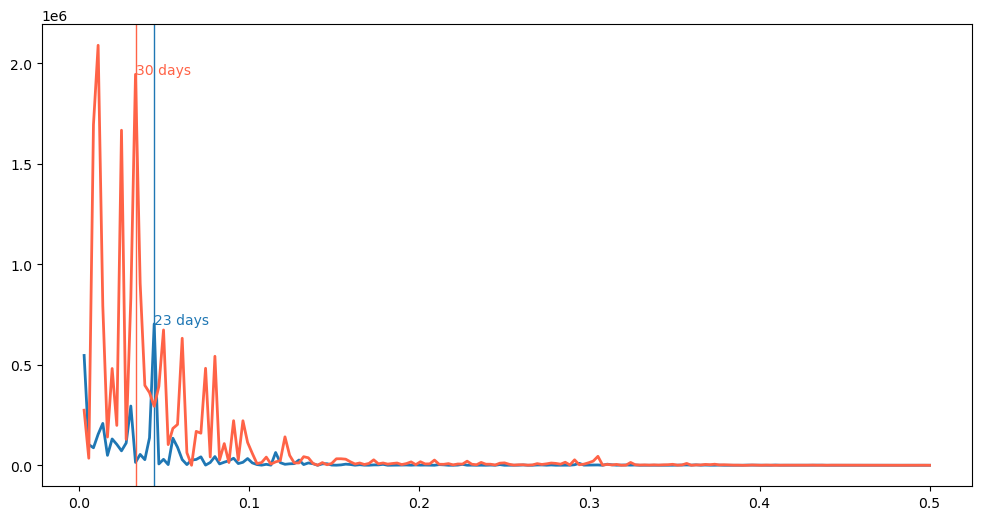

In [20]:
fig = plt.figure(figsize=(12,6))

# Model, below 500 m:
frequency, power_spectrum = get_spectrum(transport_lower_max)
plt.plot(frequency[1:], power_spectrum[1:], color='C0', linewidth=lw)
plt.text(frequency[1+power_spectrum[1:].argmax()] , power_spectrum[1:].max(), np.str(int(np.round(1/frequency[1+power_spectrum[1:].argmax()]))) + ' days', color='C0')
plt.axvline(frequency[1+power_spectrum[1:].argmax()], color='C0', linewidth=lw-1)

# Observations, below 500 m:
frequency, power_spectrum = get_spectrum(ts_total[0,:365])
plt.plot(frequency[1:], power_spectrum[1:], color='tomato', linewidth=lw)
n = 5
plt.text(frequency[n+power_spectrum[n:].argmax()] , power_spectrum[n:].max(), np.str(int(np.round(1/frequency[n+power_spectrum[n:].argmax()]))) + ' days', color='tomato')
plt.axvline(frequency[n+power_spectrum[n:].argmax()], color='tomato', linewidth=lw-1);

---

## Additional figure

Time sereis of (u, v) velocity components at morring locations

In [21]:
# Depth of mooring isntruments
Depth_M1 = [505, 950] #1006] Go a little further up in the water column to make sure we have a data point.
Depth_M2 = [496, 1497]
Depth_M3 = [501, 1000, 2498]
Depth_M4 = [507, 2006, 3002, 3505]
Depth_M5 = [980, 1980, 2980, 3675, 4178]
Depth = [Depth_M1, Depth_M2, Depth_M3, Depth_M4, Depth_M5]

Select the mooring locations (lat / lon)

In [24]:
lat_moorings = [-65.32, -64.88, -64.40, -63.26, -61.83]
lon_moorings = [112.9, 113.3, 113.3, 113.3, 113.3]
lon_moorings = [-360 + lon_moorings[i] for i in range(len(lon_moorings))]

# Select the time, lat and lon values
start_time = '2086-01-01'
end_time   = '2086-12-31'
u_daily    = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean_daily_3d_u_%.nc")
v_daily    = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean_daily_3d_v_%.nc")
u_daily_moorings = u_daily.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_moorings, method='nearest').sel(xu_ocean=lon_moorings, method='nearest')
v_daily_moorings = v_daily.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_moorings, method='nearest').sel(xu_ocean=lon_moorings, method='nearest')

In [ ]:
u_daily_moorings.load()
v_daily_moorings.load()

In [26]:
u_daily_moorings

,Array,Chunk
Bytes,2.61 MiB,700 B
Shape,"(365, 75, 5, 5)","(1, 7, 5, 5)"
Count,690592 Tasks,4015 Chunks
Type,float32,numpy.ndarray


Plotting

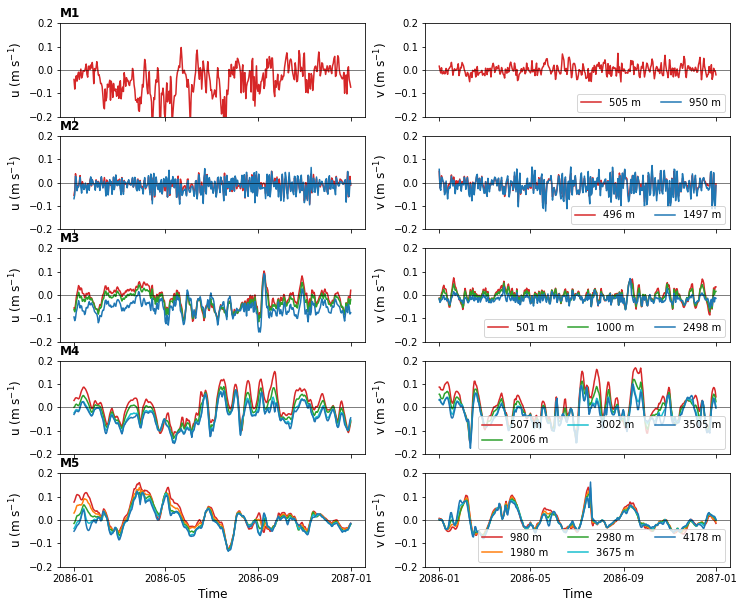

In [27]:
# Setting up figure
mooring_name = ['M1', 'M2', 'M3', 'M4', 'M5']
clr = [['C3', 'C0'], ['C3', 'C0'], ['C3', 'C2', 'C0'], ['C3', 'C2', 'C9','C0'], ['C3', 'C1', 'C2', 'C9', 'C0']]

fig = plt.figure(figsize=(12,10))
gs  = GridSpec(5, 2, hspace=0.2)

for ii in range(len(lat_moorings)):
    ax = fig.add_subplot(gs[(ii*2)])
    for tt in range(len(Depth[ii])):
        d_tmp = Depth[ii][tt]
        u_tmp = u_daily_moorings[:,:,ii,ii].sel(st_ocean=d_tmp, method='nearest')
        plt.plot(u_daily_moorings.time, u_tmp, label=str(d_tmp)+' m', color=clr[ii][tt])
    plt.ylabel('u (m s$^{-1}$)', fontsize=ft_size)
    if ii == 4:
        plt.xlabel('Time', fontsize=ft_size)
    plt.ylim(-0.2, 0.2)
    if ii < 4:
        ax.tick_params(labelbottom=False)
    plt.axhline(0, color='k', linewidth=0.5)
    plt.title(mooring_name[ii], fontsize=ft_size, fontweight='bold', loc='left')

    ax = fig.add_subplot(gs[(ii*2)+1])
    for tt in range(len(Depth[ii])):
        d_tmp = Depth[ii][tt]
        v_tmp = v_daily_moorings[:,:,ii,ii].sel(st_ocean=d_tmp, method='nearest')
        plt.plot(v_daily_moorings.time, v_tmp, label=str(d_tmp)+' m', color=clr[ii][tt])
    plt.legend(ncol=3, loc=4)
    plt.ylabel('v (m s$^{-1}$)', fontsize=ft_size)
    if ii == 4:
        plt.xlabel('Time', fontsize=ft_size)
    plt.ylim(-0.2, 0.2)
    if ii < 4:
        ax.tick_params(labelbottom=False)
    plt.axhline(0, color='k', linewidth=0.5)

# Save figure
fig_name = fig_path + 'Fig_ACCESS-om2-01_PM2016_Fig3' + '.png'
fig.savefig(fig_name, dpi=150)

Notes:
- Upper slope: variability dominated by higher frequency